In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas_ta as ta

In [2]:
class Backtest :
    def __init__(self , symbol) :
        self.symbol = symbol
        self.df = yf.download(self.symbol , interval ='1h', start='2022-06-01')
        if self.df.empty :
            print('Fail !')
        else :
            self.indicators()
            self.gen_signals()
            self.bt_loop()
            self.return_arr = self.cal_return()
            self.max_dd = self.return_arr.min()
            self.cumulative_return = (self.return_arr +1).prod() -1
    
    def indicators(self) :
        self.df['ma_20'] = self.df.Close.rolling(20).mean()
        self.df['volatile'] = self.df.Close.rolling(20).std()
        self.df['upper_bb'] = self.df.ma_20 + (2*self.df.volatile )
        self.df['lower_bb'] = self.df.ma_20 - (2*self.df.volatile )
        self.df['rsi'] = ta.momentum.rsi(self.df.Close, window=6)
        self.df.dropna(inplace = True)

    def gen_signals(self) :
        conditions = [((self.df.rsi<30)&(self.df.Close <self.df.lower_bb))
                      , ((self.df.rsi>75) &(self.df.Close > self.df.upper_bb))]
        choices = ['Buy', 'Sell']
        self.df['signal'] = np.select(conditions , choices)
        self.df.signal = self.df.signal.shift(1)
        self.df['shifted_Close'] = self.df.Close.shift(1)
        self.df.dropna(inplace = True)
        
    def bt_loop(self) :
        position = False
        buydate,selldate = [],[]
        buyprice,sellprice = [],[]

        for index,row in self.df.iterrows() :
            if position == False and row['signal']=='Buy' :
                buydate.append(index)
                buyprice.append(row.Open)
                position = True
            if position == True :
                if row['signal'] =='Sell' or row.shifted_Close <0.95*buyprice[-1]:
                    selldate.append(index)
                    buyprice.append(row.Open)
                    position = False
        self.buy_arr = self.df.loc[buydate].Open
        self.sell_arr = self.df.loc[selldate].Open

    def cal_return(self) :
        if len(self.buy_arr) > len(self.sell_arr) :
            self.buy_arr = self.buy_arr[:-1]
        return (self.sell_arr.values - self.buy_arr.values)/self.buy_arr.values
        
    def plot_chart(self) :
        plt.figure(figsize = (10,8))
        plt.plot(self.df.Close,c='b',lw=1.5)      
        plt.plot(self.df.lower_bb, c='grey' ,lw=1 , linestyle='--')
        plt.plot(self.df.upper_bb, c='grey' ,lw=1 , linestyle='--')
        plt.scatter(self.buy_arr.index,self.buy_arr.values,marker='^',c='g', s=80)
        plt.scatter(self.sell_arr.index,self.sell_arr.values,marker='v',c='r', s=80)
        plt.title(self.symbol , fontsize = 20 , fontname = 'monospace')
        plt.xlabel('Date' ,fontname = 'monospace')
        plt.ylabel('Price' ,fontname = 'monospace')

In [3]:
a = Backtest('TLT')
a.df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ma_20,volatile,upper_bb,lower_bb,rsi,signal,shifted_Close
Datetime,,,,,,,,,,,,,
2022-06-03 15:30:00-04:00,115.550003,116.059998,115.550003,116.019997,116.019997,3227365,115.908019,0.346121,116.600261,115.215778,52.452083,0,115.544998
2022-06-06 09:30:00-04:00,115.150002,115.510002,114.495003,114.514999,114.514999,3423139,115.831769,0.463567,116.758904,114.904635,32.159894,0,116.019997
2022-06-06 10:30:00-04:00,114.529999,114.540001,113.870003,113.995003,113.995003,2674459,115.726769,0.614171,116.955111,114.498427,28.112991,0,114.514999
2022-06-06 11:30:00-04:00,114.000000,114.434998,113.925003,114.059998,114.059998,1770875,115.628769,0.713294,117.055358,114.202181,29.310357,Buy,113.995003
2022-06-06 12:30:00-04:00,114.050003,114.309998,114.004997,114.165001,114.165001,2270339,115.524519,0.767988,117.060496,113.988543,31.301190,Buy,114.059998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08 11:30:00-05:00,95.595001,95.959999,95.555000,95.959999,95.959999,2838492,95.731870,0.199813,96.131496,95.332243,64.167191,0,95.599998
2024-03-08 12:30:00-05:00,95.955002,96.044998,95.839996,95.928497,95.928497,3635445,95.756294,0.191960,96.140214,95.372374,63.130691,0,95.959999
2024-03-08 13:30:00-05:00,95.930000,95.959999,95.639999,95.695000,95.695000,1930596,95.768539,0.178758,96.126054,95.411024,55.920319,0,95.928497


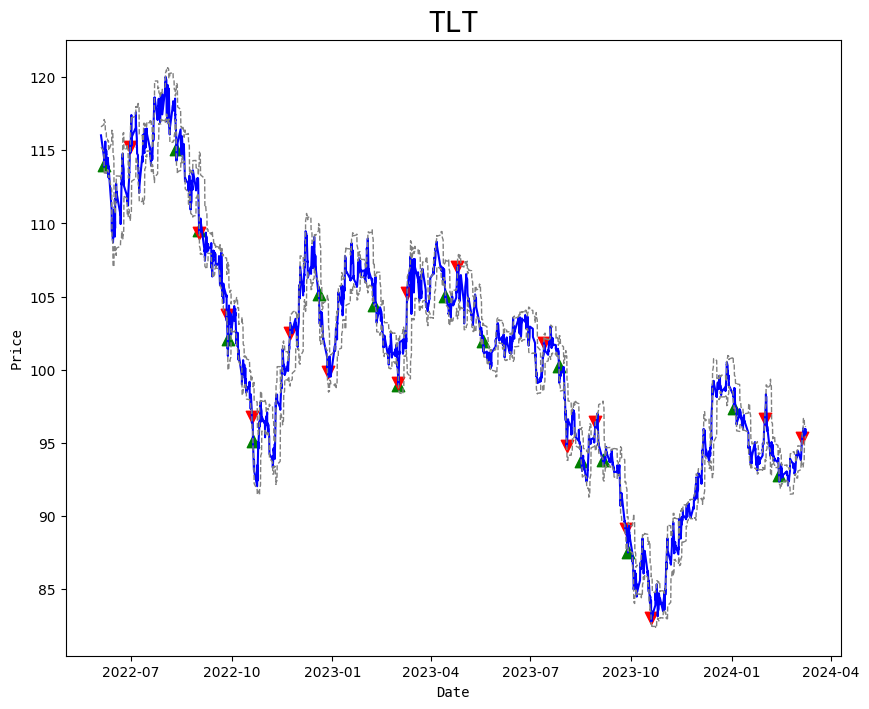

In [4]:
a.plot_chart()

In [5]:
a.return_arr

array([ 0.01061403, -0.05025406, -0.05250183, -0.05172413,  0.0777603 ,
       -0.05080793, -0.05133949,  0.0637094 ,  0.01827351, -0.00137865,
       -0.05485737,  0.02782813, -0.05026429, -0.05120674, -0.00759907,
        0.02742307])

In [6]:
a.max_dd

-0.05485736966698599

In [7]:
a.cumulative_return

-0.19200265626214963

In [8]:
b= Backtest('SPY')
b.df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ma_20,volatile,upper_bb,lower_bb,rsi,signal,shifted_Close
Datetime,,,,,,,,,,,,,
2022-06-03 15:30:00-04:00,410.946106,411.230011,409.809998,410.579987,410.579987,11879701,411.658060,2.573573,416.805206,406.510913,46.745475,0,410.940002
2022-06-06 09:30:00-04:00,414.779999,416.609009,413.660004,415.929993,415.929993,11311789,412.015559,2.648260,417.312080,406.719039,61.129142,0,410.579987
2022-06-06 10:30:00-04:00,415.920013,416.500000,412.769989,413.399994,413.399994,8141954,412.308559,2.443267,417.195092,407.422025,53.737494,0,415.929993
2022-06-06 11:30:00-04:00,413.412506,414.255005,411.165009,411.320007,411.320007,5904639,412.414558,2.345331,417.105220,407.723897,48.540826,0,413.399994
2022-06-06 12:30:00-04:00,411.315002,412.519989,410.839996,411.940002,411.940002,5356319,412.427559,2.341763,417.111084,407.744034,50.090164,0,411.320007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08 11:30:00-05:00,514.750000,515.280029,513.570007,514.630005,514.630005,11839572,512.136249,3.412920,518.962089,505.310409,57.145979,0,514.760010
2024-03-08 12:30:00-05:00,514.640015,514.840027,512.059998,512.330017,512.330017,10341053,512.401250,3.194334,518.789919,506.012581,49.490598,0,514.630005
2024-03-08 13:30:00-05:00,512.440002,513.679993,511.130005,513.460022,513.460022,10139821,512.823750,2.683204,518.190159,507.457342,52.833720,0,512.330017


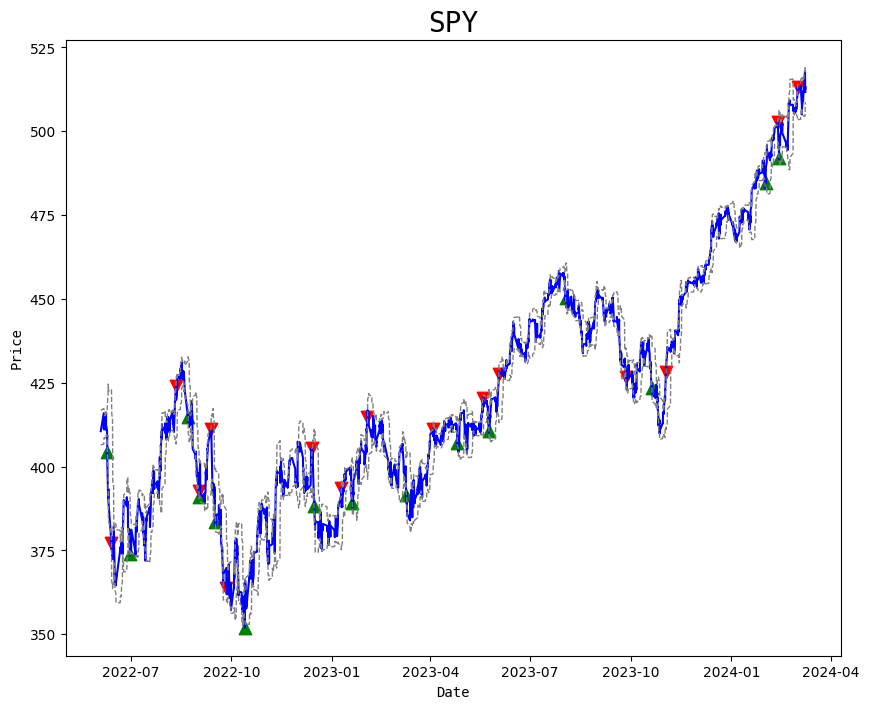

In [9]:
b.plot_chart()

In [10]:
b.return_arr

array([-0.06751545,  0.13380583, -0.05367556,  0.05244711, -0.05163373,
        0.15203003,  0.01326053,  0.06585101,  0.05041323,  0.0328102 ,
        0.04115325, -0.05210469,  0.01151529,  0.03767825,  0.04278607])

In [11]:
b.max_dd

-0.06751544513867429

In [12]:
b.cumulative_return

0.45600986664731047

In [13]:
c=  Backtest('EURUSD=X')
c.df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ma_20,volatile,upper_bb,lower_bb,rsi,signal,shifted_Close
Datetime,,,,,,,,,,,,,
2022-06-01 20:00:00+01:00,1.065757,1.066553,1.065417,1.065417,1.065417,0,1.070226,0.003222,1.076670,1.063783,28.811277,0,1.065871
2022-06-01 21:00:00+01:00,1.065530,1.066098,1.065190,1.065644,1.065644,0,1.069837,0.003285,1.076406,1.063268,30.220179,0,1.065417
2022-06-01 22:00:00+01:00,1.065644,1.066098,1.065303,1.065644,1.065644,0,1.069512,0.003364,1.076240,1.062783,30.220179,0,1.065644
2022-06-01 23:00:00+01:00,1.065644,1.065984,1.065190,1.065530,1.065530,0,1.069186,0.003421,1.076029,1.062343,29.877115,0,1.065644
2022-06-02 00:00:00+01:00,1.065530,1.065984,1.065417,1.065417,1.065417,0,1.068843,0.003439,1.075722,1.061965,29.516640,0,1.065530
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08 18:00:00+00:00,1.094212,1.094212,1.093613,1.093972,1.093972,0,1.094709,0.000934,1.096578,1.092841,49.703295,0,1.094212
2024-03-08 19:00:00+00:00,1.094092,1.094451,1.093733,1.094451,1.094451,0,1.094668,0.000926,1.096519,1.092816,52.682273,0,1.093972
2024-03-08 20:00:00+00:00,1.094571,1.094571,1.093733,1.093972,1.093972,0,1.094596,0.000921,1.096437,1.092754,49.523463,0,1.094451


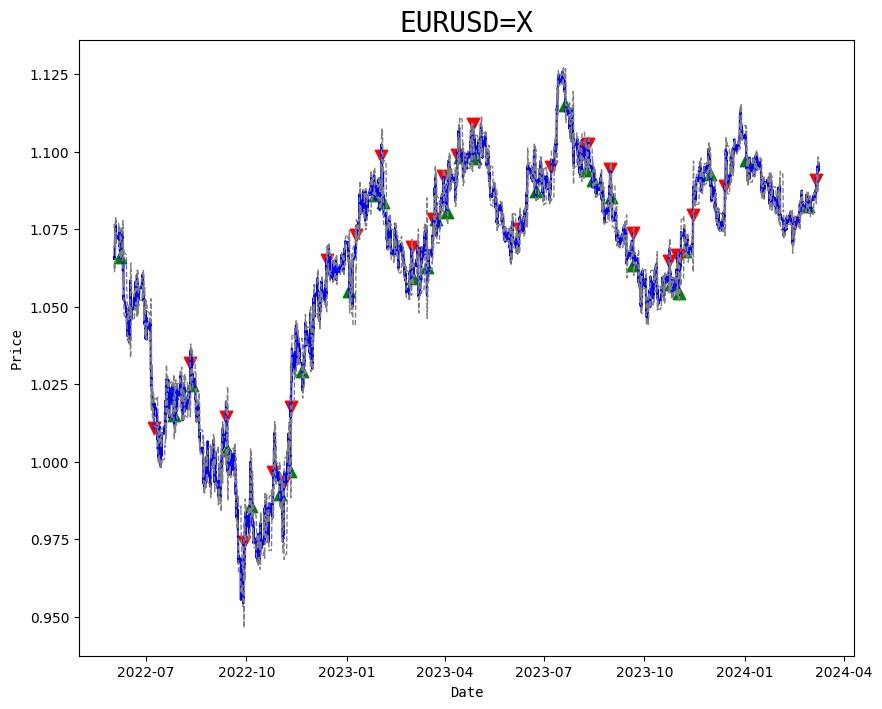

In [14]:
c.plot_chart()

In [15]:
c.return_arr

array([-0.05165262,  0.01671818, -0.0102455 , -0.02942318,  0.01116323,
        0.00407349,  0.02096689,  0.03461129,  0.01717102,  0.01164446,
       -0.01347157,  0.00768407,  0.01433966,  0.012997  ,  0.01692307,
        0.00964625, -0.02106845,  0.00722727, -0.01266098,  0.00749561,
        0.00317358, -0.01063026,  0.00127774,  0.00885234,  0.01130428,
        0.01112075, -0.00359326, -0.01852253,  0.00752616])

In [16]:
c.cumulative_return

0.062111676638288316